In [1]:
# PLAIN AND SIMPLE LINEAR SVM USING SVC KERNEL = LINEAR

import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV



data = pd.read_csv('data/train_tfidf_features.csv')
X = data.drop(columns=['id', 'label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('svc', SVC(kernel='linear',
               gamma=0.1))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svc__C': [0.1, 1, 10, 50, 100]
}

# Perform GridSearchCV to find the best regularization parameter
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro') 


print(f'Accuracy with SGDClassifier: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report with SGDClassifier:')
print(report)



# HISTORY
# first run: 0.7247599650858306, 0.6926448445963982 (6min)



In [2]:
# LINEAR SVM WITH DIFFERING REGULARISATION VALUE USING LINEARSVC
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

data = pd.read_csv('data/train_tfidf_features.csv')
X = data.drop(columns=['id', 'label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('svc', LinearSVC(penalty="l1", loss="squared_hinge", dual=False, tol=1e-3))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svc__C': [0.17385, 0.173875, 0.1739, 0.173925, 0.17395],  # Even finer range around 0.1739
    'svc__max_iter': [6000, 6200, 6300, 6400, 6500],
    'svc__loss': ['hinge','squared_hinge']
}

# Perform GridSearchCV to find the best regularization parameter
grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters: {best_params}')

""" test_dataset = pd.read_csv('data/test_tfidf_features.csv')
x_test_dataset = test_dataset.drop(columns=['id']).values
y_test_pred = best_model.predict(x_test_dataset)
predictions_df = pd.DataFrame({'id': test_dataset['id'], 'label': y_test_pred})
# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False) """



# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report:')
print(report)
""" Best parameters: {'svc__C': 0.173875, 'svc__loss': 'squared_hinge', 'svc__max_iter': 6000}
Accuracy: 0.722432353796916
F1 Score: 0.6880534155931336 with cv=5. 4 mins"""

""" Best parameters: {'svc__C': 0.17385, 'svc__loss': 'squared_hinge', 'svc__max_iter': 6000}
Accuracy: 0.722432353796916
F1 Score: 0.6880534155931336 with cv=7. 4 mins"""

ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

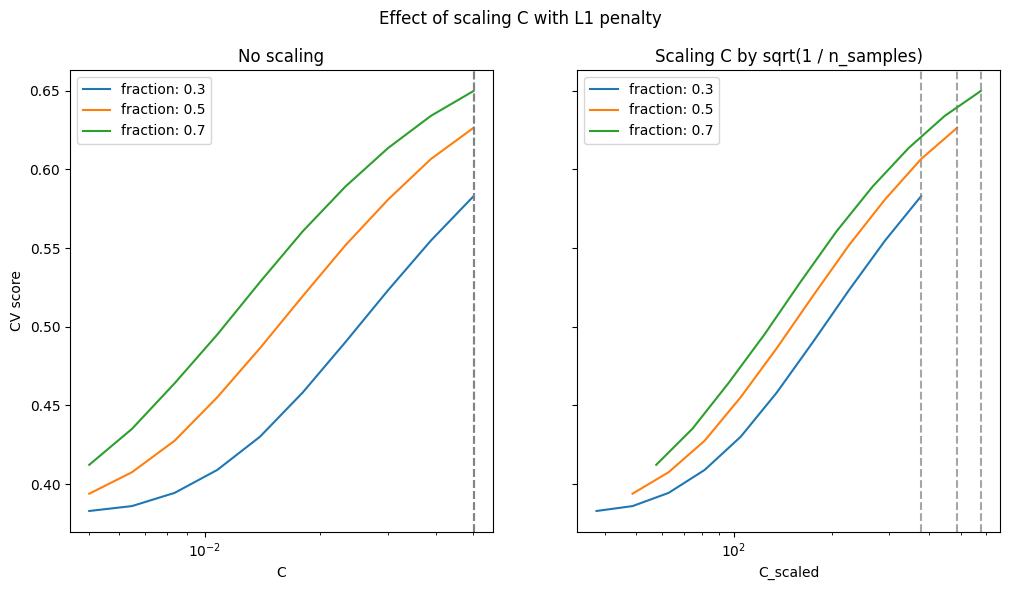

Best C for fraction: 0.3: 0.05011872336272722
Best C for fraction: 0.5: 0.05011872336272722
Best C for fraction: 0.7: 0.05011872336272722


In [4]:
# LinearSVC experimenting different regularisation term

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import ShuffleSplit, validation_curve
import matplotlib.pyplot as plt

data = pd.read_csv('data/train_tfidf_features.csv')
X = data.drop(columns=['id', 'label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_l1 = LinearSVC(penalty="l2", loss="squared_hinge", dual=False, tol=1e-3)

# Define the range of C values and train sizes
Cs = np.logspace(-2.3, -1.3, 10)
train_sizes = np.linspace(0.3, 0.7, 3)
labels = [f"fraction: {train_size}" for train_size in train_sizes]
shuffle_params = {
    "test_size": 0.3,
    "n_splits": 150,
    "random_state": 1,
}

# Initialize results dictionary
results = {"C": Cs}

# Compute validation curves for each train size
for label, train_size in zip(labels, train_sizes):
    cv = ShuffleSplit(train_size=train_size, **shuffle_params)
    train_scores, test_scores = validation_curve(
        model_l1,
        X_train,
        y_train,
        param_name="C",
        param_range=Cs,
        cv=cv,
        scoring='f1_macro',
        n_jobs=2,
    )
    results[label] = test_scores.mean(axis=1)

# Convert results to DataFrame
results = pd.DataFrame(results)

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# Plot results without scaling C
results.plot(x="C", ax=axes[0], logx=True)
axes[0].set_ylabel("CV score")
axes[0].set_title("No scaling")

for label in labels:
    best_C = results.loc[results[label].idxmax(), "C"]
    axes[0].axvline(x=best_C, linestyle="--", color="grey", alpha=0.7)

# Plot results by scaling C
n_samples = len(X_train)
for train_size_idx, label in enumerate(labels):
    train_size = train_sizes[train_size_idx]
    results_scaled = results[[label]].assign(
        C_scaled=Cs * float(n_samples * np.sqrt(train_size))
    )
    results_scaled.plot(x="C_scaled", ax=axes[1], logx=True, label=label)
    best_C_scaled = results_scaled["C_scaled"].loc[results[label].idxmax()]
    axes[1].axvline(x=best_C_scaled, linestyle="--", color="grey", alpha=0.7)

axes[1].set_title("Scaling C by sqrt(1 / n_samples)")

fig.suptitle("Effect of scaling C with L1 penalty")
plt.show()

# Find and print the best C value
for label in labels:
    best_C = results.loc[results[label].idxmax(), "C"]
    print(f"Best C for {label}: {best_C}")

In [3]:
# PLAIN AND SIMPLE LINEAR SVM USING SVC KERNEL = LINEAR WITH PCA

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,f1_score
from sklearn.decomposition import PCA

data = pd.read_csv('data/train_tfidf_features.csv')
X = data.drop(columns=['id', 'label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA(n_components=700)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train_pca, y_train)
# Make predictions
y_pred = svm_model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')


print(f'Accuracy: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report:')
print(report)


# HISTORY
# first run: 0.5609 (1min 500 components)


Accuracy: 0.5609543206284551
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.73      0.67      2153
           1       0.38      0.28      0.33      1284

    accuracy                           0.56      3437
   macro avg       0.51      0.50      0.50      3437
weighted avg       0.54      0.56      0.54      3437



In [7]:
# LINEAR SVM USING SGDClassifier SCIKIT LEARN 
# https://stackoverflow.com/questions/29704231/in-sklearn-what-is-the-difference-between-a-svm-model-with-linear-kernel-and-a-s
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score,f1_score
from sklearn.model_selection import train_test_split


data = pd.read_csv('data/train_tfidf_features.csv')
X = data.drop(columns=['id', 'label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('sgd', SGDClassifier(early_stopping=True, max_iter=5000)) #stop once validation doesnt improve
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'sgd__loss': ["squared_hinge", "hinge", "perceptron", "modified_huber"],
    'sgd__alpha':[0.000001,0.0001,0.0005,0.0006,0.0008],
}

# Perform GridSearchCV to find the best regularization parameter
grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters: {best_params}')
# Evaluate the best model on the test set

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')


print(f'Accuracy with SGDClassifier: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report with SGDClassifier:')
print(report)


# HISTORY using hinge loss
# first run: 0.7247599650858306 (14 sec with 1000 max iter)
# second run 0.7235961594413733 (14 sec with 5000 max iter)
# third run 0.7235961594413733 (14 sec with 10000 max iter)


# HISTORY using squared hinge loss
# first run: 0.6659877800407332 (1min 21 sec with 1000 max iter)
# second run 0.7235961594413733 (5min sec with 5000 max iter)


# HISTORY using Perceptoron loss
# first run: 0.6825720104742508, 0.648364347180668 (12sec with 1000 max iter)
# second run 0.6825720104742508, 0.5907522822434935 (13sec with 2000 max iter)


# HISTORY using Modified Huber loss
# first run: 0.7142857142857143, 0.6728646420942034 (15 sec with 1000 max iter)
# second run 0.7125400058190282, 0.6827629631844068 (16 sec with 2000 max iter)

# Best parameters: {'sgd__alpha': 0.0001, 'sgd__loss': 'hinge', 'sgd__max_iter': 1600} -> 0.6900 f1



Best parameters: {'sgd__alpha': 0.0001, 'sgd__loss': 'hinge', 'sgd__max_iter': 1600}
Accuracy with SGDClassifier: 0.705557171952284
F1 Score: 0.6900405004345188
Classification Report with SGDClassifier:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2153
           1       0.60      0.64      0.62      1284

    accuracy                           0.71      3437
   macro avg       0.69      0.69      0.69      3437
weighted avg       0.71      0.71      0.71      3437



In [24]:
# Radial Basis function SVM
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('data/train_tfidf_features.csv')
X = data.drop(columns=['id', 'label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



pipeline = Pipeline([
    ('rbf', SVC(kernel='rbf',
               gamma=0.1))
])

param_grid = {
    'rbf__C': [0.1,1,10,100],
    'rbf__max_iter': [6000, 6200, 6300, 6400, 6500],
    'rbf__gamma':[1e-1, 1, 1e1]
}

# Perform GridSearchCV to find the best regularization parameter
grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print(f'Best parameters: {best_params}')
# Evaluate the best model on the test set

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report:')
print(report)

# HISTORY
# first run:Accuracy: 0.6278731451847541
# Accuracy: 0.6566773348850742
# F1 Score: 0.6462896370222766

Accuracy: 0.6278731451847541
Accuracy: 0.6566773348850742
F1 Score: 0.6462896370222766
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2153
           1       0.53      0.65      0.59      1284

    accuracy                           0.66      3437
   macro avg       0.65      0.66      0.65      3437
weighted avg       0.68      0.66      0.66      3437



In [27]:
# POLY SVM
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Load the dataset
# Replace 'your_dataset.csv' with your actual dataset path
data = pd.read_csv('data/train_tfidf_features.csv')

X = data.drop(columns=['label']).values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_poly = SVC(kernel='poly', degree=5, C=1.0, coef0=1) # here we will explore different degrees

svm_poly.fit(X_train, y_train)

# Make predictions
y_pred = svm_poly.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')


print(f'Accuracy: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report:')
print(report)


Accuracy: 0.6264183881291824
F1 Score: 0.3851520572450805
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      2153
           1       0.00      0.00      0.00      1284

    accuracy                           0.63      3437
   macro avg       0.31      0.50      0.39      3437
weighted avg       0.39      0.63      0.48      3437



c:\Users\asyra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asyra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asyra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [26]:
# Sigmoid SVM
# https://stats.stackexchange.com/questions/90736/the-difference-of-kernels-in-svm


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,f1_score


data = pd.read_csv('data/train_tfidf_features.csv')

X = data.drop(columns=['label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_sigmoid = SVC(kernel='sigmoid', C=1.0, coef0=1)
svm_sigmoid.fit(X_train, y_train)

# Make predictions
y_pred = svm_sigmoid.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')


print(f'Accuracy: {accuracy}')
print(f'F1 Score: {macro_f1}')
print('Classification Report:')
print(report)


Accuracy: 0.5292406168169915
F1 Score: 0.49756365081946474
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      2153
           1       0.37      0.37      0.37      1284

    accuracy                           0.53      3437
   macro avg       0.50      0.50      0.50      3437
weighted avg       0.53      0.53      0.53      3437



https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf


using the publication above